# Bellevue University DSC640 Term Project Milestone 1 – National Database of Childcare Prices (NDCP) Data Analysis
**Author:** Zicheng (Chance) Xu

**Term:** 2025 Summer

This notebook contains preliminary data exploration to support **Milestone 1** of the term‑project.
The goal at this stage is strictly exploratory: to become familiar with the structure of the [2022 National Database of Childcare Prices](https://www.dol.gov/sites/dolgov/files/WB/NDCP2022.xlsx) (NDCP) county‑level file, come up with potential storylines, and document questions/assumptions for deeper analysis in later milestones.

## Initial Idea

Based on reading the NDCP Technical Report, there're two data sources: one about the market rate of the childcare services, and another one about the community information, such as emloyment rate, income, poverty rate, and racial distributions.

The data is interesting in that prices are reported in constant weekly units and that every observation carries metadata on urbanicity, household income, and gender-split labor-force variables—ideal for affordability and labor-supply questions. Therefore, the focus for now, since there're 370 columns, could be by quantifying how much a \\$-for-\\$ change in child-care costs moves mothers’ employment, we give state workforce and budget officials a hard, decision-ready elasticity—something they can translate directly into projected tax revenue, GDP gains, and subsidy ROI.

According to the technical report data dictionary, the columns can be categorized into the following sub categories which we can refer to later in the project (**In the order of the columns in the data, not the data dictionary**):
1. State and County names and codes
2. Study Year
3. Employment and unemployment rates, labor force participation rates, and poverty rates for different age groups and genders
4. Different kinds of income and earnings, including age groups
5. Total population and population by different races
6. Number of households and number of households by age groups and who's working or single mother
7. Percent of civilians emloyed by different occupations and age and gender groups:
    - Management, business,science, and arts
    - Service
    - Sales and office
    - Natural resources, construction, and maintenance
    - Production, transportation, and material moving
8. All other fields with i in the beginning, indicating if that related field was imputed or not

From column index EB in the data:

9. Median prices for center-based care by different age groups
10. Median prices of family child care by different age groups
11. 75th percentile price of center based care by different age groups
12. 75th percentile price of family child care by different age groups
13. All other fields with i in the beginning, value indicating summary of imputations made to the related field

From column index HL in the data:

14. Median prices for center-based care aggregated weekly by infant, toddler, preschool groups
15. 75th percentile price of center based care by infant, toddler, preschool groups
16. Median prices of family child care aggregated weekly by infant, toddler, preschool groups
17. 75th percentile price of family child care by infant, toddler, preschool groups

From column index IJ in the data:

18. State FIPS Code
19. Employment and unemployment rates, labor foce participation rates, and poverty rates for different age groups and genders, at the **state level**
20. Different kinds of income and earnings, including age groups, at the **state level**
21. Total population and population by different races, at the **state level**
22. Number of households and number of households by age groups and who's working or single mother, at the **state level**
23. Percent of civilians emloyed by different occupations and age and gender groups, at the **state level**:
    - Management, business,science, and arts
    - Service
    - Sales and office
    - Natural resources, construction, and maintenance
    - Production, transportation, and material moving
24. All other fields with i in the beginning, indicating if that related field was imputed or not

## Initial Data Load

In [5]:
# Initial loading of necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (10, 6)

In [6]:
DATA_PATH = Path('NDCP2022.xlsx')  # I put the file in same directory as the notebook

# Checking the file existence
if not DATA_PATH.exists():
    raise FileNotFoundError('Please make sure NDCP2022.xlsx is in the working directory.')

# peek at sheet names & first few rows to confirm layout
xl = pd.ExcelFile(DATA_PATH, engine='openpyxl')
print('Sheets:', xl.sheet_names)
df_head = xl.parse(xl.sheet_names[0], nrows=5)
display(df_head.head())

Sheets: ['County_LevelNDCP_v8_update2008_']


,STATE_NAME,STATE_ABBREVIATION,COUNTY_NAME,COUNTY_FIPS_CODE,STUDYYEAR,EMR_16,FEMR_16,MEMR_16,EMR_20to64,FEMR_20to64,MEMR_20to64,UNR_16,FUNR_16,MUNR_16,UNR_20to64,FUNR_20to64,MUNR_20to64,FLFPR_20to64,FLFPR_20to64_UNDER6,FLFPR_20to64_6to17,FLFPR_20to64_UNDER6_6to17,MLFPR_20to64,PR_F,PR_P,MHI,MFI,MFI_2022,ME,FME,MME,MHI_2022,ME_2022,FME_2022,MME_2022,TOTALPOP,ONERACE,ONERACE_W,ONERACE_B,ONERACE_I,ONERACE_A,ONERACE_H,ONERACE_OTHER,TWORACES,HISPANIC,HOUSEHOLDS,H_UNDER6_BOTHWORK,H_UNDER6_FWORK,H_UNDER6_MWORK,H_UNDER6_SINGLEM,H_6to17_BOTHWORK,H_6to17_FWORK,H_6to17_MWORK,H_6to17_SINGLEM,EMP_M,MEMP_M,FEMP_M,EMP_SERVICE,MEMP_SERVICE,FEMP_SERVICE,EMP_SALES,MEMP_SALES,FEMP_SALES,EMP_N,MEMP_N,FEMP_N,EMP_P,MEMP_P,FEMP_P,iEMR_16,iFEMR_16,iMEMR_16,iEMR_20to64,iFEMR_20to64,iMEMR_20to64,iUNR_16,iFUNR_16,iMUNR_16,iUNR_20to64,iFUNR_20to64,iMUNR_20to64,iFLFPR_20to64,iFLFPR_20to64_UNDER6,iFLFPR_20to64_6to17,iFLFPR_20to64_UNDER6_6to17,iMLFPR_20to64,iPR_F,iPR_P,iMHI,iMFI,iME,iFME,iMME,iMHI_2022,iMFI_2022,iME_2022,iFME_2022,iMME_2022,iTOTALPOP,iONERACE,iONERACE_W,iONERACE_B,iONERACE_I,iONERACE_A,iONERACE_H,iONERACE_OTHER,iTWORACES,iHISPANIC,iHOUSEHOLDS,iH_UNDER6_BOTHWORK,iH_UNDER6_FWORK,iH_UNDER6_MWORK,iH_UNDER6_SINGLEM,iH_6to17_BOTHWORK,iH_6to17_FWORK,iH_6to17_MWORK,iH_6to17_SINGLEM,iEMP_M,iMEMP_M,iFEMP_M,iEMP_SERVICE,iMEMP_SERVICE,iFEMP_SERVICE,iEMP_SALES,iMEMP_SALES,iFEMP_SALES,iEMP_N,iMEMP_N,iFEMP_N,iEMP_P,iMEMP_P,iFEMP_P,MCBto5,MC6to11,MC12to17,MC18to23,MC24to29,MC30to35,MC36to41,MC42to47,MC48to53,MC54toSA,MCSA,MFCCBto5,MFCC6to11,MFCC12to17,MFCC18to23,MFCC24to29,MFCC30to35,MFCC36to41,MFCC42to47,MFCC48to53,MFCC54toSA,MFCCSA,_75CBto5,_75C6to11,_75C12to17,_75C18to23,_75C24to29,_75C30to35,_75C36to41,_75C42to47,_75C48to53,_75C54toSA,_75CSA,_75FCCBto5,_75FCC6to11,_75FCC12to17,_75FCC18to23,_75FCC24to29,_75FCC30to35,_75FCC36to41,_75FCC42to47,_75FCC48to53,_75FCC54toSA,_75FCCSA,iMCBto5,iMC6to11,iMC12to17,iMC18to23,iMC24to29,iMC30to35,iMC36to41,iMC42to47,iMC48to53,iMC54toSA,iMCSA,iMFCCBto5,iMFCC6to11,iMFCC12to17,iMFCC18to23,iMFCC24to29,iMFCC30to35,iMFCC36to41,iMFCC42to47,iMFCC48to53,iMFCC54toSA,iMFCCSA,i_75CBto5,i_75C6to11,i_75C12to17,i_75C18to23,i_75C24to29,i_75C30to35,i_75C36to41,i_75C42to47,i_75C48to53,i_75C54toSA,i_75CSA,i_75FCCBto5,i_75FCC6to11,i_75FCC12to17,i_75FCC18to23,i_75FCC24to29,i_75FCC30to35,i_75FCC36to41,i_75FCC42to47,i_75FCC48to53,i_75FCC54toSA,i_75FCCSA,MCINFANT,MCInfant_flag,MCTODDLER,MCToddler_flag,MCPRESCHOOL,MCPreschool_flag,_75CINFANT,_75CInfant_flag,_75CTODDLER,_75CToddler_flag,_75CPRESCHOOL,_75CPreschool_flag,MFCCINFANT,MFCCInfant_flag,MFCCTODDLER,MFCCToddler_flag,MFCCPRESCHOOL,MFCCPreschool_flag,_75FCCINFANT,_75FCCInfant_flag,_75FCCTODDLER,_75FCCToddler_flag,_75FCCPRESCHOOL,_75FCCPreschool_flag,STATE_FIPS,EMR_16_STATE,FEMR_16_STATE,MEMR_16_STATE,EMR_20to64_STATE,FEMR_20to64_STATE,MEMR_20to64_STATE,UNR_16_STATE,FUNR_16_STATE,MUNR_16_STATE,UNR_20to64_STATE,FUNR_20to64_STATE,MUNR_20to64_STATE,FLFPR_20to64_STATE,FLFPR_20to64_UNDER6_STATE,FLFPR_20to64_6to17_STATE,FLFPR_20to64_UNDER6_6to17_STATE,MLFPR_20to64_STATE,PR_F_STATE,PR_P_STATE,MHI_STATE,MFI_STATE,MFI_2022_STATE,ME_STATE,FME_STATE,MME_STATE,MHI_2022_STATE,ME_2022_STATE,FME_2022_STATE,MME_2022_STATE,TOTALPOP_STATE,ONERACE_STATE,ONERACE_W_STATE,ONERACE_B_STATE,ONERACE_I_STATE,ONERACE_A_STATE,ONERACE_H_STATE,ONERACE_OTHER_STATE,TWORACES_STATE,HISPANIC_STATE,HOUSEHOLDS_STATE,H_UNDER6_BOTHWORK_STATE,H_UNDER6_FWORK_STATE,H_UNDER6_MWORK_STATE,H_UNDER6_SINGLEM_STATE,H_6to17_BOTHWORK_STATE,H_6to17_FWORK_STATE,H_6to17_MWORK_STATE,H_6to17_SINGLEM_STATE,EMP_M_STATE,MEMP_M_STATE,FEMP_M_STATE,EMP_SERVICE_STATE,MEMP_SERVICE_STATE,FEMP_SERVICE_STATE,EMP_SALES_STATE,MEMP_SALES_STATE,FEMP_SALES_STATE,EMP_N_STATE,MEMP_N_STATE,FEMP_N_STATE,EMP_P_STATE,MEMP_P_STATE,FEMP_P_STATE,iEMR_16_STATE,iFEMR_16_STATE,iMEMR_16_STATE,iEMR_20to64_STATE,iFEMR_20to64_STATE,iMEMR_20to64_STATE,iUNR_16_STATE,iFUNR_16_STATE,iMUNR_16_STATE,iUNR_20to64_STATE,iFUNR_20to64_STATE,iMUNR_20to64_STATE,iFLFPR_20to64_STATE,iFLFPR_2

Data looks good, let's do full load.

In [8]:
df = xl.parse(xl.sheet_names[0])
print('Shape:', df.shape)

Shape: (48308, 370)


## Initial Data Analysis
For the simplicity of the initial analysis, let's pattern search fields for family child care and center-based care, but only on median prices, ignoring imputation differences and other statistics numbers such as 75th percentile.

In [10]:
# Define the logic to find median prices
def is_center_median(col):
    return col.startswith('MC') 

def is_fam_median(col):
    return col.startswith('MFCC')

center_med_cols = [c for c in df.columns if is_center_median(c)]
fam_med_cols    = [c for c in df.columns if is_fam_median(c)]

print(f'Center-based median columns found: {len(center_med_cols)}')
center_med_cols[:10]

Center-based median columns found: 17


['MCBto5',
 'MC6to11',
 'MC12to17',
 'MC18to23',
 'MC24to29',
 'MC30to35',
 'MC36to41',
 'MC42to47',
 'MC48to53',
 'MC54toSA']

In [11]:
print(f'Family child-care median columns found: {len(fam_med_cols)}')
fam_med_cols[:10]

Family child-care median columns found: 17


['MFCCBto5',
 'MFCC6to11',
 'MFCC12to17',
 'MFCC18to23',
 'MFCC24to29',
 'MFCC30to35',
 'MFCC36to41',
 'MFCC42to47',
 'MFCC48to53',
 'MFCC54toSA']

To see the trend and affordability of the childcare prices, lets build a benchmark age-band, making the infant group as the benchmark.

In [13]:
# Creating benchmark groups
infant_center_col = 'MCBto5' if 'MCBto5' in df.columns else center_med_cols[0]
infant_fam_col    = 'MFCCBto5' if 'MFCCBto5' in df.columns else (fam_med_cols[0] if fam_med_cols else None)
print('Using infant price column:', infant_center_col)

Using infant price column: MCBto5


For simplicity, let's use MHI (Median Household Income) for affordability metric calculation since it's handy.

Also, we need to converts weekly sticker price into an annual burden and normalises by local purchasing power; this is the metric budget directors understand best.

In [44]:
# Compute the affordability metric
income_col = 'MHI'
df['afford_center'] = df[infant_center_col] * 52 / df[income_col]
if infant_fam_col:
    df['afford_fam'] = df[infant_fam_col] * 52 / df[income_col]

# Show top 10 by affordability (i.e., highest cost-to-income ratio)
print('Top 10 most costly infant childcare cost ratio - Center Based:')
print(
    df[['STATE_NAME', 'COUNTY_NAME', 'STUDYYEAR', 'afford_center']]
    .sort_values(by='afford_center', ascending=False)
    .head(10)
)

if infant_fam_col:
    print('\nTop 10 most costly infant childcare cost ratio - Family Based:')
    print(
        df[['STATE_NAME', 'COUNTY_NAME', 'STUDYYEAR', 'afford_fam']]
        .sort_values(by='afford_fam', ascending=False)
        .head(10)
    )

Top 10 most costly infant childcare cost ratio - Center Based:
       STATE_NAME          COUNTY_NAME  STUDYYEAR  afford_center
27461    New York         Bronx County       2017       0.605930
27462    New York         Bronx County       2018       0.543006
44864  Washington       Whitman County       2014       0.540331
44444  Washington         Ferry County       2014       0.512063
44669  Washington       Pacific County       2014       0.487693
44654  Washington      Okanogan County       2014       0.484656
44684  Washington  Pend Oreille County       2014       0.479757
27463    New York         Bronx County       2019       0.478647
44670  Washington       Pacific County       2015       0.468185
44399  Washington      Columbia County       2014       0.468065

Top 10 most costly infant childcare cost ratio - Family Based:
        STATE_NAME      COUNTY_NAME  STUDYYEAR  afford_fam
8812         Idaho    Owyhee County       2013    0.352711
8811         Idaho    Owyhee County     

Let's visualize the national median infant childcare price trend.

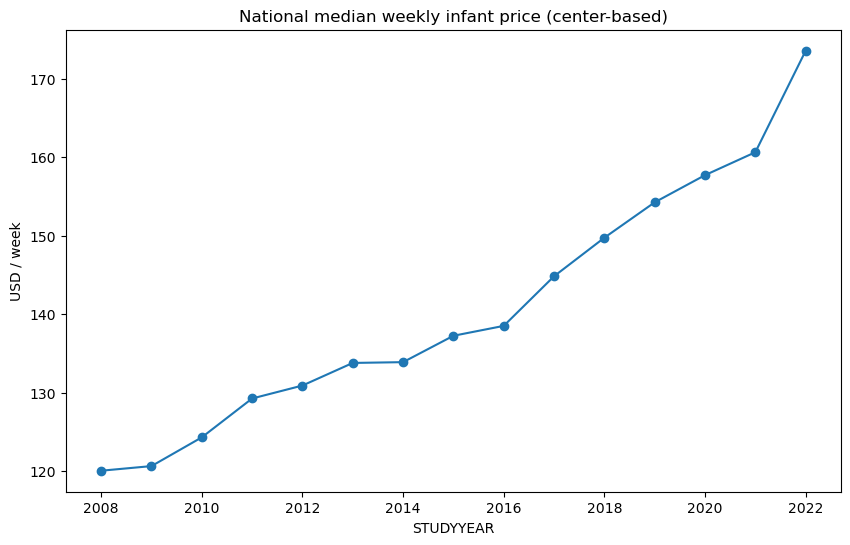

In [17]:
trend = (df.groupby('STUDYYEAR')[infant_center_col]
         .median()
         .sort_index())
trend.plot(marker='o', title='National median weekly infant price (center-based)')
plt.ylabel('USD / week')
plt.show()

Clear and steady upward trend of the national median infant childcare prices, at an accelarated pace from 2021 to 2022. More than 42% increase over the 14 years.

What about the labor force participation vs the childcare prices? 

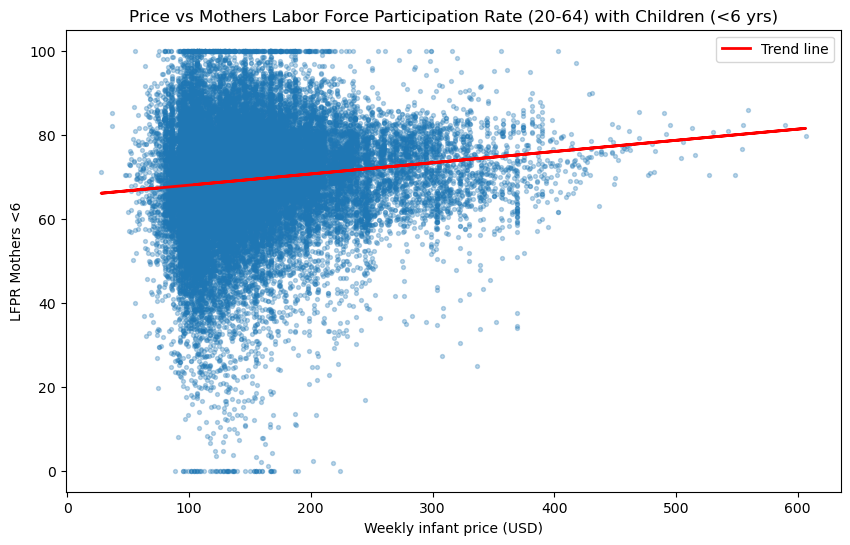

In [20]:
# Define x and y
x = df[infant_center_col]
y = df['FLFPR_20to64_UNDER6']

# Clean data: remove NaNs and infinite values
mask = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
x_clean = x[mask]
y_clean = y[mask]

# Fit the trend line using np.polyfit
slope, intercept = np.polyfit(x_clean, y_clean, 1)
trend_line = slope * x_clean + intercept

# Plot
plt.scatter(x_clean, y_clean, s=8, alpha=0.3)
plt.plot(x_clean, trend_line, color='red', linewidth=2, label='Trend line')
plt.title('Price vs Mothers Labor Force Participation Rate (20-64) with Children (<6 yrs)')
plt.xlabel('Weekly infant price (USD)')
plt.ylabel('LFPR Mothers <6')
plt.legend()
plt.show()

In [57]:
slope

0.02667651763595909

Counties with higher prices appear to have higher mothers’ participation rates, which makes sense as financial burden rises when the childcare prices increase.

What about the cost difference between the center based and family based care?

Number of counties analysed (year 2022): 2,555
Top-quartile (≥ $216/wk) counties:  641
Top-decile   (≥ $285/wk) counties:  258

Average family-care discount in TOP 25 % cost counties: 26.6%
Average family-care discount in TOP 10 % cost counties: 29.9%


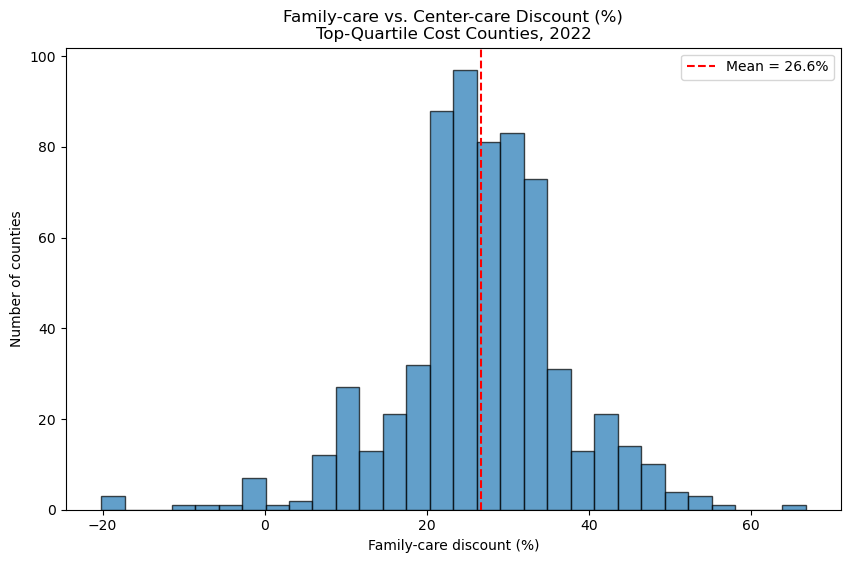

In [49]:
# Pick year and variables for comparison
YEAR = 2022
cols_needed = [infant_center_col, infant_fam_col]

df_yr = (df[df["STUDYYEAR"] == YEAR]
         .dropna(subset=cols_needed)             # keep rows with both prices present
         .copy())

# Calculate family-care discount/premium as a % of center price
df_yr["fam_discount_pct"] = (
    (df_yr[infant_center_col] - df_yr[infant_fam_col])
    / df_yr[infant_center_col] * 100
)

# 3) Pick the *highest-cost* counties (top quartile or top decile)
q75 = df_yr[infant_center_col].quantile(0.75)    # 75th-percentile cutoff
q90 = df_yr[infant_center_col].quantile(0.90)    # 90th-percentile cutoff

hi_cost_q75 = df_yr[df_yr[infant_center_col] >= q75]
hi_cost_q90 = df_yr[df_yr[infant_center_col] >= q90]

print(f"Number of counties analysed (year {YEAR}): {len(df_yr):,}")
print(f"Top-quartile (≥ ${q75:,.0f}/wk) counties:  {len(hi_cost_q75):,}")
print(f"Top-decile   (≥ ${q90:,.0f}/wk) counties:  {len(hi_cost_q90):,}")

# 4) Compute the average discount
avg_q75 = hi_cost_q75["fam_discount_pct"].mean()
avg_q90 = hi_cost_q90["fam_discount_pct"].mean()

print(f"\nAverage family-care discount in TOP 25 % cost counties: {avg_q75:.1f}%")
print(f"Average family-care discount in TOP 10 % cost counties: {avg_q90:.1f}%")


plt.hist(hi_cost_q75["fam_discount_pct"], bins=30, alpha=0.7, edgecolor="k")
plt.axvline(avg_q75, color="red", linestyle="--", label=f"Mean = {avg_q75:.1f}%")
plt.title(f"Family-care vs. Center-care Discount (%)\nTop-Quartile Cost Counties, {YEAR}")
plt.xlabel("Family-care discount (%)")
plt.ylabel("Number of counties")
plt.legend()
plt.show()

Thus, the NDCP has usable price data for 2,555 counties in 2022 (both center-based and family child-care figures present).

There are 641 counties in the top quartile of the price distribution( ≥ \\$216 / week), and 258 counties in the top decile of the price distribution ( ≥ \\$285 / week).

In the top-quartile counties, family child care is about 27 % cheaper than center care on average. In the very highest-cost decile, the discount widens to about 30 %.

It's insightful that in the priciest U.S. counties, switching from a center to a licensed family child-care provider typically trims one-quarter to one-third off the weekly infant-care bill, offering sizable savings for parents facing the steepest sticker prices.

In [53]:
# Save a slimmed-down dataset for future milestones, just in case

# keep = ['STATE_NAME', 'COUNTY_NAME', 'COUNTY_FIPS_CODE', 'STUDYYEAR',
#         infant_center_col, income_col, 'afford_center']
# if infant_fam_col:
#     keep.extend([infant_fam_col, 'afford_fam'])
# if 'FLFPR_20to64_Under6' in df.columns:
#     keep.append('FLFPR_20to64_Under6')

# slim = df[keep]
# slim.to_parquet('ndcp_slim.parquet', index=False)

## Scratch-pad — field notes & next steps  

### Quick take-aways from today’s run
- **Center-based infant prices:** national median rose from **\$120 → \$160 → >\$170 per week** (2008 → 2021 → 2022) — a **42 % nominal jump** across 14 years, with the steepest single-year bump in 2021-22.  
- **Affordability pain:** worst-case county breaks **60 % of median household income** for center-based infant care; top family-care burden is ~35 %.  
- **Labour-force scatter:** cross-section shows a **positive slope**: Counties with higher prices appear to have higher mothers’ participation rates.  Need to confirm hypothesis: higher-income metro counties drive both high prices *and* higher LFPR.  Needs multivariate controls.
- **Home vs. center gap:** family infant care (`MFCCBto5`) is **~ 27-30 % cheaper** than center care (`MCBto5`) in the costliest counties.  

### Open questions / caveats
1. **Income denominator** – currently raw `MHI`; should switch to deflated `MHI_2022` when we deflate prices, to keep burden metric in real terms.  
2. **Positive LFPR slope** – likely confounded by income & urbanicity; need fixed-effects panel or at least partial correlations.  
3. **Composite “Infant 0-11 mos”** – audience may ask; requires combining `Bto5` and `6to11` bands with `_Infant_flag`.

### Action items for Milestone 2
- Further analysis.   
- Export tidy panel `ndcp_panel_v1.parquet` (key fields + imputation flags) for Tableau dashboard prototype.  
